In [44]:
import urllib2

In [45]:
from bs4 import BeautifulSoup

In [46]:
import re

In [47]:
import pandas as pd

In [48]:
import numpy as np

In [49]:
from os import path

In [50]:
from PIL import Image

In [51]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline

In [53]:
from collections import Counter

In [69]:
#We need to check for NULL values in advice section
def advice_null(in_list):
    for j in range(len(in_list)):
    #Check if 'Advice' exist in that element of the list, then replace value with 'Advice'
        if in_list[j].findAll('p', string = 'Advice to Management'):
            in_list[j] = in_list[j].findAll('p',{"class":" adviceMgmt mainText truncateThis wrapToggleStr"})
    #If the element has a missing value, then we fill it with NULL
        else:
            in_list[j] = None
    return in_list

#We need to check for NULL values in location section 
def null_loc(ilist):
    for i in range(len(ilist)):
    #Check if 'Location' exists in that element of the list, then replace the value with 'Location'
        if ilist[i].findAll('span',{"class":"authorLocation middle"}):
            ilist[i] = ilist[i].findAll('span',{"class":"authorLocation middle"})
    #If the element has a missing value, then we fill it with NUll
        else:
            ilist[i] = None
    return ilist

#We can extract the data from the website using soup webscraping 
def get_data(soup_obj):
    pros_row = soup_obj.findAll('p',{"class":" pros mainText truncateThis wrapToggleStr"})
    cons_row = soup_obj.findAll('p',{"class":" cons mainText truncateThis wrapToggleStr"})
    quote_row = soup_obj.findAll('span',{"class":"summary"})
    date_row = soup_obj.findAll('time',{"class":"date subtle small"})
    advice_row = advice_null(soup_obj.findAll('div',{"class":" tbl fill prosConsAdvice truncateData"}))
    etoile_row = soup_obj.findAll('span',{"class":"value-title"})
    author_row = soup_obj.findAll('span',{"class":"authorJobTitle middle reviewer"})
    location_row = null_loc(soup_obj.findAll('span',{"class":"authorInfo tbl hideHH"}))
  
    return pros_row, cons_row, quote_row, date_row, advice_row, etoile_row, author_row, location_row

#-------------First we need to clean up the embedded HTML tags that the data comes in with--------------------------

def clean_data(obj_row):
    nlist = []
    for row in obj_row:
        nrow_str = str(row)
        clean = re.compile("<.*?>")
        clean_row = (re.sub(clean,'',nrow_str))
        nlist.append(clean_row)
    return nlist

#-------------------Quotes will be further cleaned here---------------

#The main quote for the website comes with quotation marks,
#to eliminate them we strip the list.       
def clean_quote(qlist):
    for i in range(len(qlist)):
        qlist[i] = qlist[i].strip('[]"')
    return qlist

#-----------------Time for star reviews---------------------------------

#The rating is within a tag in HTML, so in order to find this we go ahead
#and search within the tags
#We also have to get rid of the first star that belongs to the title
def etoile(etoile):
    star = []
    #netoile = []
    if len(etoile) > 10:
        for i in range(len(etoile)):
            star.append(etoile[i].get("title"))
        premier = star.pop(0)
        netoile = etoile_clean(star)
        return netoile
  
    elif len(etoile) >= 0 and len(etoile) <= 10:
        for j in range(len(etoile)):
            star.append(etoile[j].get("title"))
        netoile = etoile_clean(star)
        return netoile
    else:
        print("Error")
        
def etoile_clean(star):
    new_star = []
    for j in range(len(star)):
        star[j] = star[j].split('.')
        new_star.append(star[j][0])
    return new_star

#------------------Lastly, author cleaning--------------------------------------

#The author list is composed of two parts, the author and the title.               
#In order to compensate for this, we divide the list into both parts respectively.
def split_auteur(alist):
    liste_travaille = []
    liste_titre = []
    for i in range(len(alist)):
        alist[i] = alist[i].split('-')
        liste_travaille.append(alist[i][0])
        liste_titre.append(alist[i][1].strip(' '))
    novo_travaille = clean_travaille(liste_travaille)
    return novo_travaille, liste_titre


def clean_travaille(liste_trav):
    list_emp = []
    for i in range(len(liste_trav)):
        liste_trav[i] = liste_trav[i].split(' ')
        list_emp.append(liste_trav[i][0])
    return list_emp

def df_data(inlist, nlist):
    df_list = pd.DataFrame(inlist, index = list(range(len(inlist))))  #Need to add an index every 10 elements
    dfh_list = pd.DataFrame(nlist)
    frames = [dfh_list,df_list]
    df = pd.concat(frames, ignore_index = True)
    ndf = df.rename(columns = df.iloc[0])
    new_df = ndf.drop(0)
    return new_df

def bar_count(count, limit):
    ignore_list = ['to','To','TO',
               'a','A',
               'None','NONE',
               'and','And','AND',
               'are','Are','ARE',
               'is','Is','IS',
               'in','IN','In',
               'it','IT','It',
               'the','THE','The',
               'of','OF','Of',
               'with','With','WITH',
               'i','I',
               'for','FOR','For',
               'can','CAN','Can',
               'that','That','THAT',
               'will','Will','WILL',
               'was','Was','WAS',
               'what','What','WHAT',
               'at','At','AT',
               'but','But','BUT',
               'as','As','AS',
               'or','Or','OR',
               'an','An','AN',
               'so','So','SO']
    cword_count = []
    cval_count = []
    for i in range(len(count)):
        if count[i][1] > limit and count[i][0] not in ignore_list:
            cword_count.append(count[i][0])
            cval_count.append(count[i][1])
    return cword_count, cval_count

def gen_bar(cword, cval, str_title):
    pos = np.arange(len(cword))
    plt.figure(figsize = (15,10))
    plt.title(str_title)
    plt.bar(pos, cval, align = 'center')
    plt.xticks(pos, cword, rotation = 'vertical')
    plt.show()
    
def gen_wc(wordcloud):
    plt.figure(figsize = (15,10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

In [70]:
def wc_generator():
    #First we need to scrape the data and read it in with beautiful soup
    web_number = input("Enter the number of URL's that will be used for this analysis: ")
    
    pros_list = []
    cons_list = []
    quote_list = []
    date_list = []
    advice_list = []
    status_list = []
    title_list = []
    location_list = []
    rate_list = []
    
    for i in range(web_number):
        exec("web" + str(i+1) + "= raw_input('Enter the website URL to be analyzed:')")
        exec("req" + str(i+1) + "= urllib2.Request(web" + str(i+1) +", headers = {'User-Agent':'Magic Brower'})")
        exec("con" + str(i+1) + "= urllib2.urlopen(req" + str(i+1) +")")
        exec("soup" + str(i+1) + "= BeautifulSoup(con" + str(i+1) + ".read())")
        exec('rpros%s, rcons%s, rquote%s, rdate%s, radvice%s, rstar%s, rauthor%s, rlocation%s = get_data(soup%s)' % (i+1,i+1,i+1,i+1,i+1,i+1,i+1,i+1,i+1))
        
        
        #Cleaning data time!
        exec('pros%s = clean_data(rpros%s)' % (i+1,i+1))
        exec('cons%s = clean_data(rcons%s)' % (i+1,i+1))
        exec('quote%s = clean_data(rquote%s)' % (i+1,i+1))
        exec('date%s = clean_data(rdate%s)' % (i+1,i+1))
        exec('advice%s = clean_data(radvice%s)' % (i+1,i+1))
        exec('author%s = clean_data(rauthor%s)' % (i+1,i+1))
        exec('location%s = clean_data(rlocation%s)' % (i+1,i+1))
        
        exec('nquote%s = clean_quote(quote%s)' % (i+1,i+1))
        exec('nadvice%s = clean_quote(advice%s)' % (i+1,i+1))
        exec('nlocation%s = clean_quote(location%s)' % (i+1,i+1))
        
        exec('nstar%s = etoile(rstar%s)' % (i+1,i+1))
        
        exec('status%s, title%s = split_auteur(author%s)' % (i+1,i+1,i+1))
        
        #Now that the data is clean, let's put it inside of a dataframe
        exec('p%s = df_data(pros%s, ["PROS"])' % (i+1,i+1))
        exec('c%s = df_data(cons%s, ["CONS"])' % (i+1,i+1))
        exec('qt%s = df_data(nquote%s, ["QUOTE"])' % (i+1,i+1))
        exec('dt%s = df_data(date%s, ["DATE"])' % (i+1,i+1))
        exec('ad%s = df_data(nadvice%s, ["ADVICE"])' % (i+1,i+1))
        exec('stat%s = df_data(status%s, ["STATUS"])' % (i+1,i+1))
        exec('tit%s = df_data(title%s, ["TITLE"])' % (i+1,i+1))
        exec('loc%s = df_data(nlocation%s, ["LOCATION"])' % (i+1, i+1))
        exec('rate%s = df_data(nstar%s, ["RATING"])' % (i+1,i+1))
        
        #Time to combine together the data from multiple pages
        exec('pros_list.append(p%s)') % (i+1)
        exec('cons_list.append(c%s)') % (i+1)
        exec('quote_list.append(qt%s)') % (i+1)
        exec('date_list.append(dt%s)') % (i+1)
        exec('advice_list.append(ad%s)') % (i+1)
        exec('status_list.append(stat%s)') % (i+1)
        exec('title_list.append(tit%s)') % (i+1)
        exec('location_list.append(loc%s)') % (i+1)
        exec('rate_list.append(rate%s)') % (i+1)
        
    join_pros = pd.concat(pros_list, ignore_index = True)

    join_cons = pd.concat(cons_list, ignore_index = True)

    join_quote = pd.concat(quote_list, ignore_index = True)

    join_date = pd.concat(date_list, ignore_index = True)

    join_advice = pd.concat(advice_list, ignore_index = True)

    join_status = pd.concat(status_list, ignore_index = True)

    join_title = pd.concat(title_list, ignore_index = True)

    join_location = pd.concat(location_list, ignore_index = True)

    join_rate = pd.concat(rate_list, ignore_index = True)
        
    chc_db = pd.concat([join_rate,join_quote,join_date,join_pros,join_cons,join_advice,join_status,join_title,join_location], axis = 1)

    #Before the word cloud, let's generate a bar plot to see what are the most popular words
    #First we count the words using a counter and print them in order to see what limit we want on our bar plot(s)
    
    count_pros = Counter(" ".join(chc_db["PROS"]).split(" ")).items()
    print("The PROS word count is the following: ")
    print(count_pros)
    print("\n")
    
    count_cons = Counter(" ".join(chc_db["CONS"]).split(" ")).items()
    print("The CONS word count is the following: ")
    print(count_cons)
    print("\n")
    
    count_quote = Counter(" ".join(chc_db["QUOTE"]).split(" ")).items()
    print("The QUOTE word count is the following: ")
    print(count_quote)
    print("\n")
    
    count_advice = Counter(" ".join(chc_db["ADVICE"]).split(" ")).items()
    print("The ADVICE word count is the following: ")
    print(count_advice)
    print("\n")
    
    count_location = Counter(" ".join(chc_db["LOCATION"]).split(" ")).items()
    print("The LOCATION word count is the following: ")
    print(count_location)
    print("\n")
    
    cword_pros = []
    cval_pros = []
    cword_cons = []
    cval_cons = []
    cword_quote = []
    cval_quote = []
    cword_advice = []
    cval_advice = []
    
    print("Please review the word count for each section and approximate a lower bound.")
    
    pros_limit = input("Enter the limit for pros: ")
    cword_pros, cval_pros = bar_count(count_pros, pros_limit)
    
    cons_limit = input("Enter the limit for cons: ")
    cword_cons, cval_cons = bar_count(count_cons, cons_limit)
    
    advice_limit = input("Enter the limit for advice: ")
    cword_advice, cval_advice = bar_count(count_advice, advice_limit)
    
    quote_limit = input("Enter the limit for quote: ")
    cword_quote, cval_quote = bar_count(count_quote, quote_limit)
    
    location_limit = input("Enter the limit for location: ")
    cword_location, cval_location = bar_count(count_location, location_limit)

    print("Let's start generating some plots!!")
    
    gen_bar(cword_location, cval_location, "Popular words in LOCATION section")
    
    gen_bar(cword_pros, cval_pros, "Popular words in PROS section")
    text_pros = " ".join(review for review in chc_db.PROS)
    pros_wordcloud = WordCloud().generate(text_pros)
    gen_wc(pros_wordcloud)
    
    gen_bar(cword_cons, cval_cons, "Popular words in CONS section")
    text_cons = " ".join(review1 for review1 in chc_db.CONS)
    cons_wordcloud = WordCloud().generate(text_pros)
    gen_wc(cons_wordcloud)
    
    gen_bar(cword_advice, cval_advice, "Popular words in ADVICE section")
    text_advice = " ".join(review2 for review2 in chc_db.ADVICE)
    advice_wordcloud = WordCloud().generate(text_advice)
    gen_wc(advice_wordcloud)
    
    gen_bar(cword_quote, cval_quote, "Popular words in QUOTE section")
    text_quote = " ".join(review3 for review3 in chc_db.QUOTE)
    quote_wordcloud = WordCloud().generate(text_quote)
    gen_wc(quote_wordcloud)
    

Enter the number of URL's that will be used for this analysis: 10
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P2.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P3.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P4.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P5.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P6.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P7.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Reviews/CHC-Consulting-Reviews-E806647_P8.htm
Enter the website URL to be analyzed:https://www.glassdoor.com/Re

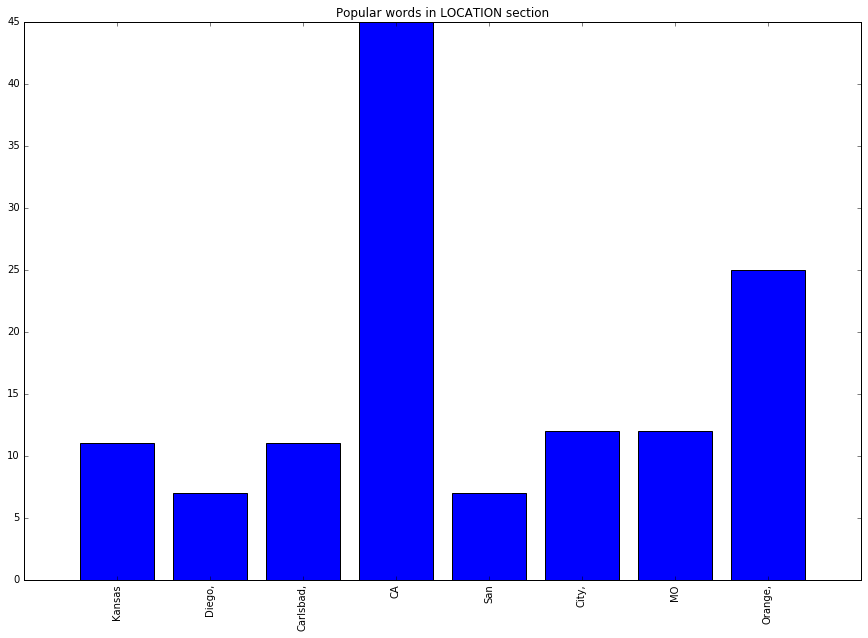

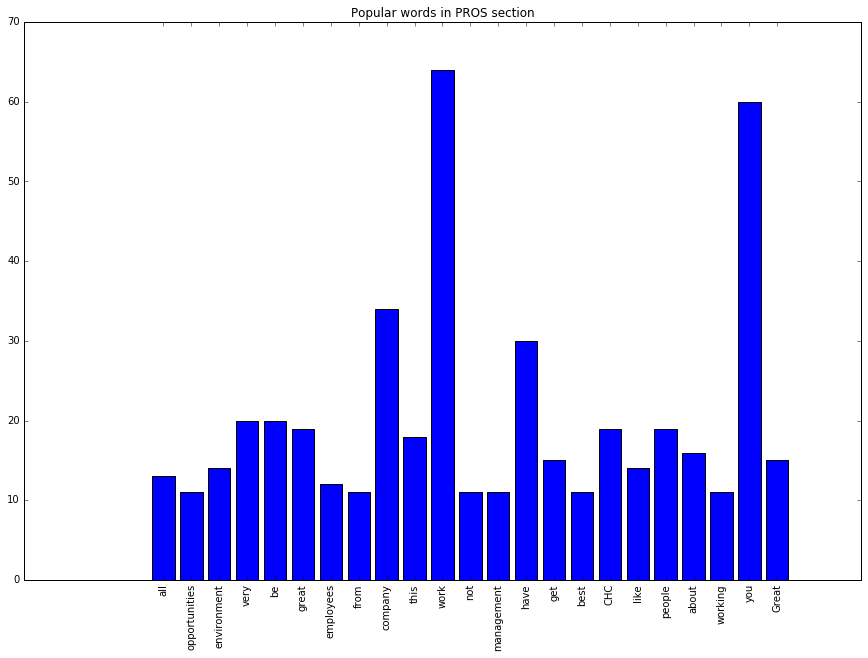

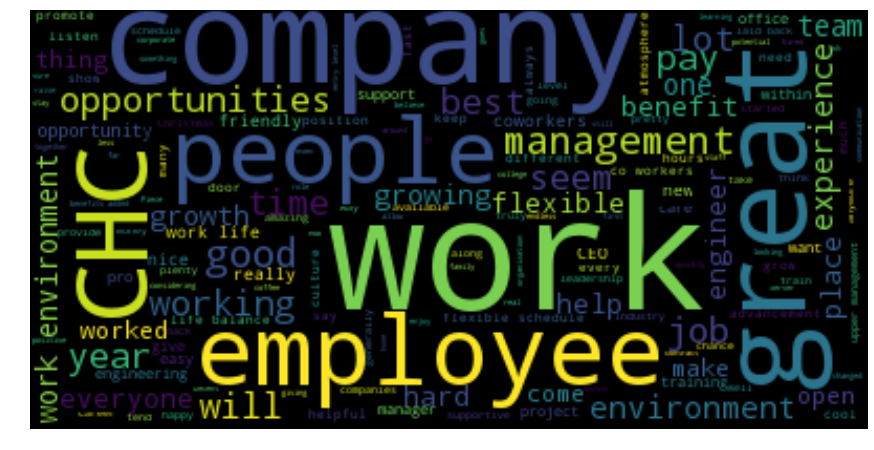

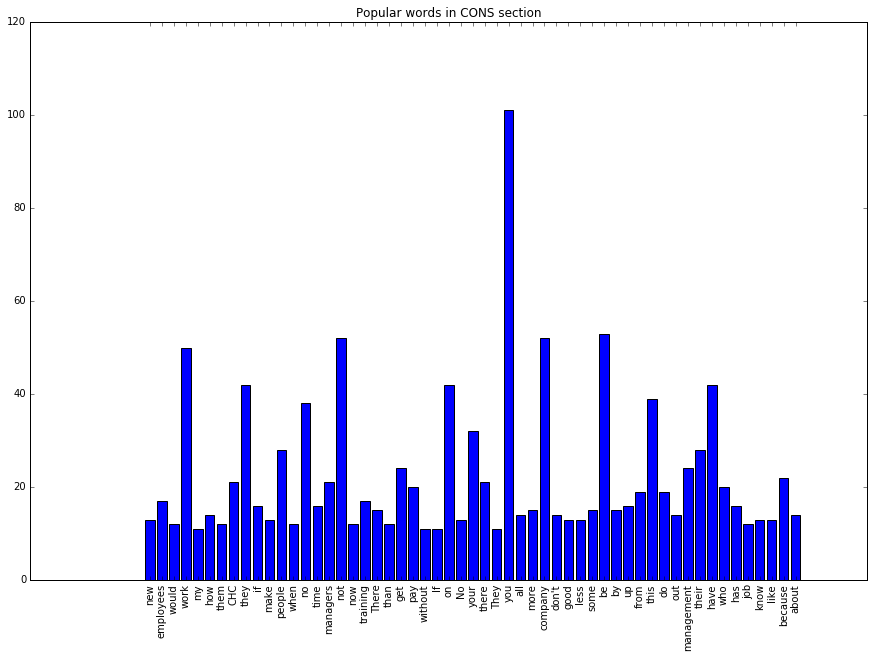

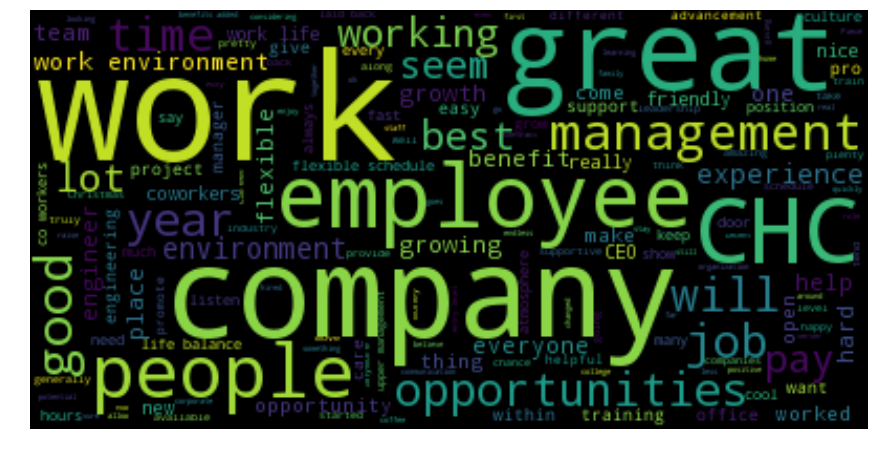

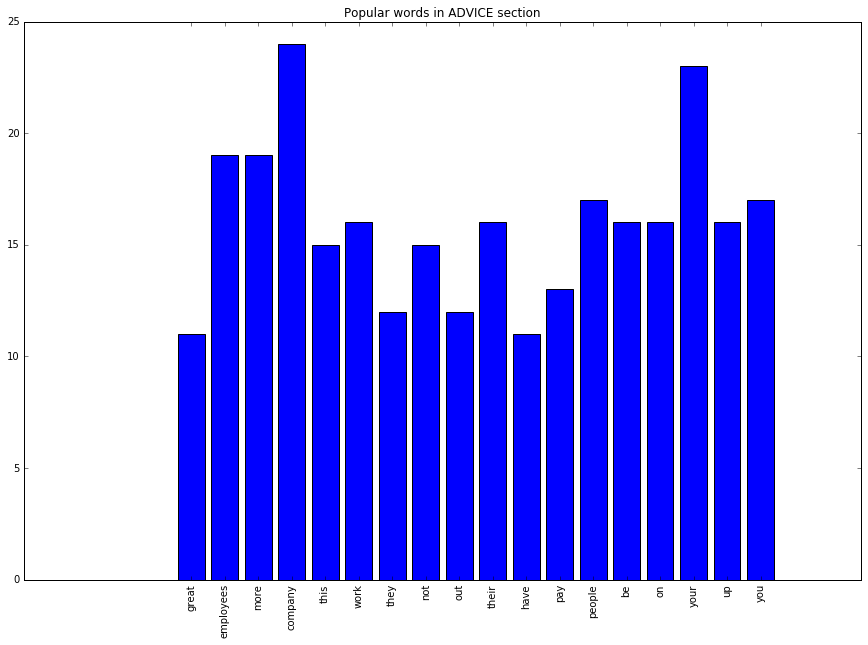

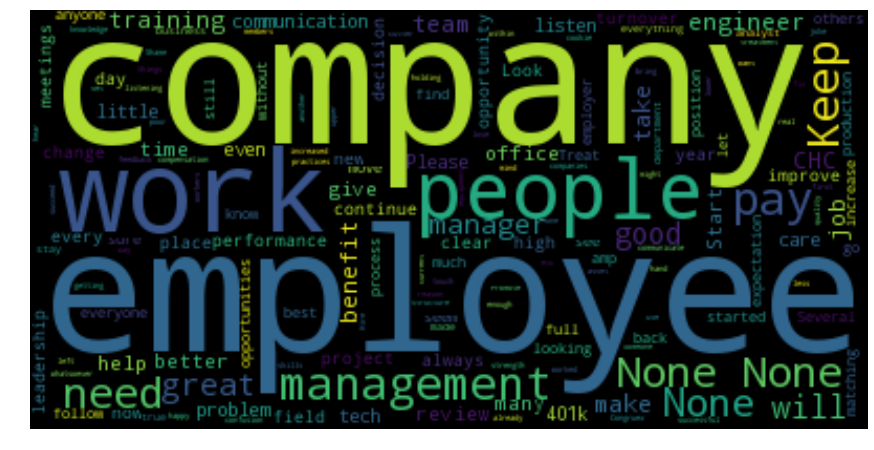

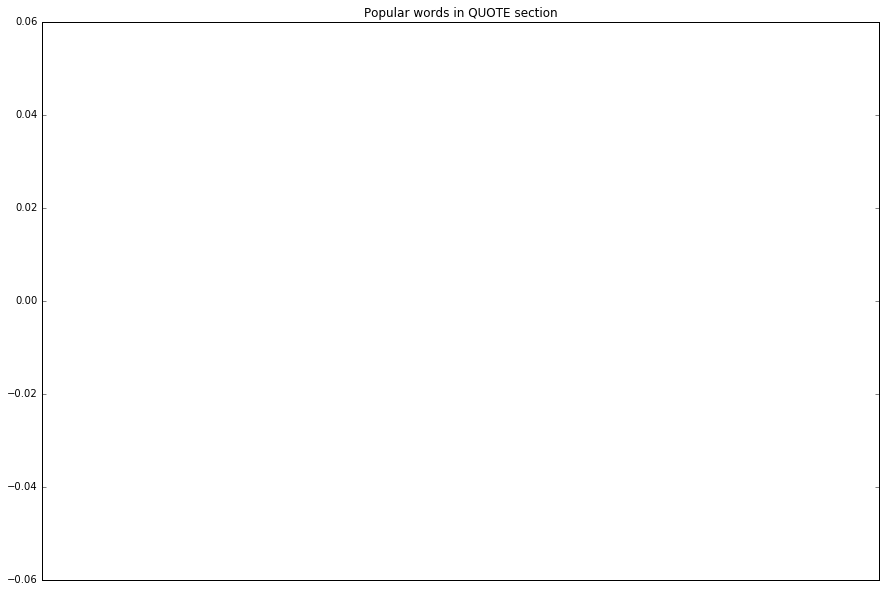

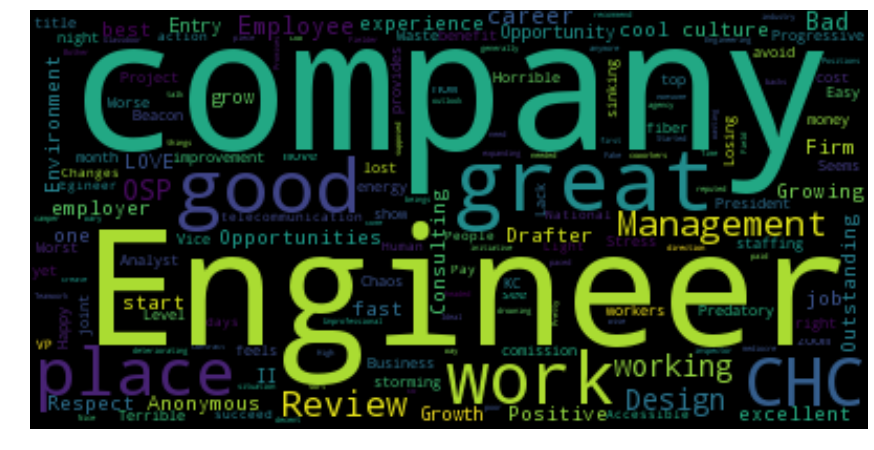

In [72]:
wc_generator()